[['W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/1402/0.png'
  'W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/1402/10.png'
  'W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/1852/0.png']]


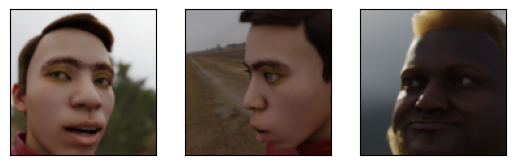

test: 1


100%|██████████| 1/1 [00:00<00:00, 42.35it/s, accuracy=1, loss=0]

tensor(5.9775, device='cuda:0')
tensor(8.6007, device='cuda:0')
average loss: 0.0
accuracy: 100.0%
0.031000000017229468 s


In [2]:
import pandas as pd
import numpy as np
import time
import warnings
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn as nn
from torch import optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from Variables import Variables
from DataLoader import FaceDataset
from Model import Model, Optimizer, TripletLoss, Schedular

def accurate(anc, pos, neg, margin):
    anc_pos = torch.pairwise_distance(anc, pos, p=2).mean()
    anc_neg = torch.pairwise_distance(anc, neg, p=2).mean()
    print(anc_pos)
    print(anc_neg)
    if anc_neg-anc_pos >= margin:
        return True
    else:
        return False

if __name__ == "__main__":
    # warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.init")

    path = "Data/Dataset.csv"
    data = pd.read_csv(path)
    data = data.values
    np.random.shuffle(data)
    test = data[:1]
    print(test)
    test = [['W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/1989/0.png',
  'W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/1989/5.png',
  'W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/878/54.png']]
#     test = [['W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/1980/0.png',
#   'W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/1980/51.png',
#   'W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/871/54.png']]

    for sample in test:
        anc, pos, neg = sample
        anc = plt.imread(anc)
        pos = plt.imread(pos)
        neg = plt.imread(neg)
        images = [anc, pos, neg]
        for i in range(len(images)):
            plt.subplot(1, 3, i+1)
            plt.imshow(images[i])
            plt.xticks([]),plt.yticks([])
        plt.show()


    test = FaceDataset(test)
    variables = Variables()
    test = DataLoader(test, batch_size = variables.batch_size_test_val, shuffle=False)

    print("test:", len(test))
    
    
    
    device = "cuda"
    model = Model(in_channels=variables.in_channels, embedding_size=variables.emembedding_size, p_dropout=variables.p_dropout, p_linear_dropout=variables.p_linear_dropout)
    tripletloss = TripletLoss(margin=variables.margin, p=variables.p)
    model.load_state_dict(torch.load('Weights/model_epoch_7.pth'))
    model.to(device)
    model.eval()
    test_margin = 0.05
    s = time.monotonic()
    with torch.no_grad():
        cost = 0.0
        accuracy = 0
        loop_val = tqdm(enumerate(test, 1), total=len(test), leave=True)
        for n, val_batch in loop_val:
            anc, pos, neg = val_batch
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
            anc = model.forward(anc)
            pos = model.forward(pos)
            neg = model.forward(neg)
            accuracy += accurate(anc, pos, neg, test_margin)
            loss = tripletloss.loss(anc, pos, neg)
            cost += loss.item()
            loop_val.set_postfix(loss=loss.item(), accuracy=accuracy/n)
        avg_loss = cost/len(test)
    print(f"average loss: {str(avg_loss)}")
    print("accuracy:", str((accuracy*100)/n)+"%")
    print(time.monotonic()-s, "s")


# [['W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/1980/0.png'
#   'W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/1980/51.png'
#   'W:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/871/54.png']]

In [3]:
import torch
from Model import Model, Optimizer, TripletLoss, Schedular
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
from Variables import Variables
variables = Variables()
torch.__version__

'2.3.1+cu118'

In [4]:
# transform = transforms.Compose([
#     # transforms.resize((112, 112))
#     # transforms.ToTensor()
# ])
image1 = read_image('D:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/0/0.png', mode=ImageReadMode.RGB).float()
image2 = read_image('D:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/0/1.png', mode=ImageReadMode.RGB).float()
image3 = read_image('D:/Projects/Facial-Encoding-Generator/Models/Datasets/FaceRecognition/labels-72/1/0.png', mode=ImageReadMode.RGB).float()
images = [image1, image2, image3]
images = torch.stack(images)
images = images/255.0
# image = image.unsqueeze(0)
images.shape

torch.Size([3, 3, 112, 112])

In [5]:
model = Model(in_channels=variables.in_channels, embedding_size=variables.emembedding_size, p_dropout=variables.p_dropout, p_linear_dropout=variables.p_linear_dropout)
tripletloss = TripletLoss(margin=variables.margin, p=variables.p)
device = "cuda"
model = model.to(device)
images = images.to(device)

In [71]:
model.eval()
a = model.forward(images)

torch.Size([3, 12544])


In [72]:
a[0]

tensor([-1.8797e-02, -1.1156e-02,  1.7930e-02,  3.9841e-02, -5.1041e-03,
        -1.4262e-02,  2.5949e-02, -4.6400e-04,  4.0729e-02, -7.8825e-03,
        -3.4278e-02,  2.8733e-02, -1.6935e-02,  1.9195e-02, -8.0084e-03,
         2.0357e-02,  4.6409e-02, -3.0605e-02,  2.0239e-02,  3.7992e-02,
        -1.1087e-02,  2.4482e-02,  6.5100e-03,  3.9375e-02,  8.6236e-03,
        -1.3146e-02,  3.2691e-02,  1.2306e-02,  2.0067e-02,  4.0466e-02,
         8.7034e-03,  1.1092e-04,  2.7325e-03,  1.4458e-02,  3.0854e-02,
        -3.3869e-02, -3.7966e-02, -2.3890e-02, -2.7777e-02, -1.5965e-02,
        -2.5231e-02,  6.2379e-03, -2.6182e-03, -2.1665e-04,  4.0123e-02,
         2.7197e-02,  2.7191e-03, -7.4734e-03, -2.2442e-02, -9.2628e-03,
         1.6593e-02,  6.8978e-03, -2.4422e-02,  9.4452e-03,  1.7400e-02,
        -2.6848e-02,  4.7886e-02, -2.3102e-02, -2.5226e-02, -3.8690e-02,
         7.9275e-03,  3.3004e-02,  2.6170e-02, -1.9218e-02, -2.6348e-02,
         2.3034e-02, -1.0099e-02, -1.5999e-02,  6.5

In [73]:
a[1]

tensor([-1.8748e-02, -1.1099e-02,  1.7638e-02,  3.9799e-02, -5.0620e-03,
        -1.4100e-02,  2.6007e-02, -4.7573e-04,  4.0525e-02, -7.9154e-03,
        -3.4306e-02,  2.8661e-02, -1.6885e-02,  1.9214e-02, -8.0263e-03,
         2.0317e-02,  4.6499e-02, -3.0536e-02,  2.0117e-02,  3.8048e-02,
        -1.0972e-02,  2.4560e-02,  6.5155e-03,  3.9459e-02,  8.7642e-03,
        -1.3071e-02,  3.2816e-02,  1.2217e-02,  2.0037e-02,  4.0514e-02,
         8.6646e-03,  6.4446e-05,  2.5045e-03,  1.4499e-02,  3.0888e-02,
        -3.3875e-02, -3.8005e-02, -2.4003e-02, -2.7969e-02, -1.5923e-02,
        -2.5211e-02,  6.2660e-03, -2.6196e-03, -4.1102e-04,  4.0241e-02,
         2.7327e-02,  2.8119e-03, -7.4651e-03, -2.2522e-02, -9.1663e-03,
         1.6519e-02,  6.9166e-03, -2.4405e-02,  9.4613e-03,  1.7333e-02,
        -2.6753e-02,  4.7874e-02, -2.3021e-02, -2.5326e-02, -3.8507e-02,
         8.0090e-03,  3.2967e-02,  2.6278e-02, -1.9301e-02, -2.6408e-02,
         2.3010e-02, -9.9994e-03, -1.6259e-02,  6.5

In [74]:
a[2]

tensor([-1.8826e-02, -1.1354e-02,  1.7892e-02,  3.9953e-02, -5.2585e-03,
        -1.4267e-02,  2.6096e-02, -4.9054e-04,  4.0602e-02, -7.9177e-03,
        -3.4254e-02,  2.8557e-02, -1.6867e-02,  1.9199e-02, -7.9927e-03,
         2.0305e-02,  4.6191e-02, -3.0600e-02,  2.0406e-02,  3.7992e-02,
        -1.0969e-02,  2.4343e-02,  6.5201e-03,  3.9322e-02,  8.6684e-03,
        -1.3231e-02,  3.2810e-02,  1.2290e-02,  1.9933e-02,  4.0522e-02,
         8.8302e-03,  1.9367e-04,  2.7756e-03,  1.4423e-02,  3.0862e-02,
        -3.3863e-02, -3.7845e-02, -2.3908e-02, -2.7673e-02, -1.5844e-02,
        -2.5284e-02,  6.3874e-03, -2.4743e-03, -1.2484e-04,  4.0140e-02,
         2.7233e-02,  2.7180e-03, -7.4054e-03, -2.2450e-02, -9.2648e-03,
         1.6596e-02,  6.8936e-03, -2.4323e-02,  9.4201e-03,  1.7494e-02,
        -2.6898e-02,  4.7872e-02, -2.3119e-02, -2.5146e-02, -3.8802e-02,
         7.8305e-03,  3.2855e-02,  2.6285e-02, -1.9193e-02, -2.6355e-02,
         2.3119e-02, -1.0017e-02, -1.5948e-02,  6.5

In [75]:
print(torch.pairwise_distance(a[0], a[1]))
print(torch.pairwise_distance(a[0], a[2]))

tensor(0.0012, device='cuda:0', grad_fn=<NormBackward1>)
tensor(0.0010, device='cuda:0', grad_fn=<NormBackward1>)


In [17]:
print(list(model.state_dict().values())[0][0])

tensor([[[ 0.0543,  0.0812,  0.0778, -0.0596,  0.0695, -0.0580,  0.0242],
         [-0.0714,  0.0445,  0.0423, -0.0421, -0.0319,  0.0284,  0.0169],
         [ 0.0495,  0.0287,  0.0115, -0.0514, -0.0755,  0.0502,  0.0317],
         [-0.0237,  0.0032, -0.0514, -0.0392,  0.0812, -0.0386, -0.0628],
         [-0.0294, -0.0135, -0.0297, -0.0028, -0.0777,  0.0102, -0.0267],
         [ 0.0424, -0.0377,  0.0011,  0.0153,  0.0782,  0.0542, -0.0472],
         [ 0.0739, -0.0092, -0.0804,  0.0505,  0.0451,  0.0483, -0.0333]],

        [[ 0.0753,  0.0698, -0.0564,  0.0593,  0.0448, -0.0272, -0.0468],
         [ 0.0647,  0.0194,  0.0508, -0.0408,  0.0214, -0.0804, -0.0766],
         [ 0.0221, -0.0036, -0.0247, -0.0683, -0.0569, -0.0594,  0.0425],
         [ 0.0789, -0.0143, -0.0335, -0.0491, -0.0469, -0.0330, -0.0658],
         [ 0.0516,  0.0676, -0.0294, -0.0383, -0.0160, -0.0448,  0.0183],
         [-0.0163,  0.0039,  0.0110,  0.0385, -0.0069, -0.0401, -0.0431],
         [ 0.0755,  0.0087,  0.0648,

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
for p in model.parameters():
    if p.requires_grad:
        print(p.shape)


torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64, 64, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([192, 64, 1, 1])
torch.Size([192])
torch.Size([192, 192, 3, 3])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([384, 384, 1, 1])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 1, 1])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([640, 12544])
torch.Size([640])
torch.Size([640])
torch.Size([640])
torch.Size([128, 640])
torch.Size([128])


In [58]:
named_params = model.named_parameters()
for p in named_params:
    print(p[0], p[1].shape)

conv.0.weight torch.Size([64, 3, 7, 7])
conv.0.bias torch.Size([64])
conv.2.weight torch.Size([64])
conv.2.bias torch.Size([64])
conv.4.weight torch.Size([64, 64, 3, 3])
conv.4.bias torch.Size([64])
conv.5.weight torch.Size([64, 64, 1, 1])
conv.5.bias torch.Size([64])
conv.6.weight torch.Size([64])
conv.6.bias torch.Size([64])
conv.8.weight torch.Size([192, 64, 1, 1])
conv.8.bias torch.Size([192])
conv.10.weight torch.Size([192, 192, 3, 3])
conv.10.bias torch.Size([192])
conv.11.weight torch.Size([384, 192, 3, 3])
conv.11.bias torch.Size([384])
conv.12.weight torch.Size([384, 384, 1, 1])
conv.12.bias torch.Size([384])
conv.13.weight torch.Size([256, 384, 3, 3])
conv.13.bias torch.Size([256])
conv.14.weight torch.Size([256, 256, 1, 1])
conv.14.bias torch.Size([256])
conv.16.weight torch.Size([256, 256, 3, 3])
conv.16.bias torch.Size([256])
fc.0.weight torch.Size([640, 12544])
fc.0.bias torch.Size([640])
fc.1.weight torch.Size([640])
fc.1.bias torch.Size([640])
fc.3.weight torch.Size([12

In [ ]:
model

In [2]:
from tqdm import tqdm
a = [31, 32, 33]
a = iter(a)
iterobj = enumerate(a)
loop = tqdm(iterobj)
for i, j in loop:
    print(i, j)
    break
loop = tqdm(iterobj, total=2, leave=True)
for i, j in loop:
    print("..")
    print(i, j)

0it [00:00, ?it/s]


0 31


100%|██████████| 2/2 [00:00<?, ?it/s]

..
1 32
..
2 33
